In [1]:
# import tensorflow as tf
# sess = tf.Session()
import keras
from keras import backend as K
# K.set_session(sess)
import h5py

from keras.models import Model
from keras.layers import Dense, LSTM, Input, Embedding, GRU, Masking, Dropout, Lambda, Flatten, concatenate, Conv1D, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.preprocessing.sequence import pad_sequences

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

# import pandas 

from process_data import *
import os
from n_gram_lm import *


Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10016508947827866520
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11332668621
locality {
  bus_id: 1
}
incarnation: 15544126383942351444
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [3]:
# Problem parameters
max_mfe_len = 1800
max_phrase_len = 300
n_energies = 40
n_letters = 27+1 # 26 chars, 1 space, 1 blank
blank_idx = n_letters - 1

In [4]:
model_name = "densenet_char_b1.l5.f128.k7.relu"

In [5]:
print "Loading model", model_name
json_file = open("saved_models/"+model_name)
json = json_file.read()
model = keras.models.model_from_json(json)
sgd = Adam(lr=0.001)
print "Compiling..."
# the loss calc occurs elsewhere, so use a dummy lambda func for the loss (y_pred is actually loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred, 'letter_probs': lambda y_true, y_pred: 0*y_pred}, optimizer=sgd)

print "Looking for weight files..."

filenames = os.listdir("saved_weights")
model_regex = r"^"+model_name+r"-([0-9]+)-([+-]?([0-9]*[.])?[0-9]+)\.hdf5"
highest_epoch = None
latest = None
for k in filenames:
    match =  re.match(model_regex, k)
    if match:

        epochs_done = int(match.group(1))
        val_loss = float(match.group(2))
        print "File", k, "contains weights after {} epochs achieving validation loss: {}".format(epochs_done, val_loss)
        # If this is the first file, or if there is a more recent one
        if not highest_epoch or epochs_done > highest_epoch:
            highest_epoch = max(epochs_done, highest_epoch)
            latest = k
        else:
            continue
if latest:
    print "Latest weights are from {}".format(latest)

    print "Loading weights..."
    model.load_weights('saved_weights/'+latest)
    print "Done"
else:
    print "Didn't find any weight files for this model!"
    epochs_done = 0

Loading model densenet_char_b1.l5.f128.k7.relu
Compiling...
Looking for weight files...
File densenet_char_b1.l5.f128.k7.relu-07-239.60.hdf5 contains weights after 7 epochs achieving validation loss: 239.6
File densenet_char_b1.l5.f128.k7.relu-02-311.03.hdf5 contains weights after 2 epochs achieving validation loss: 311.03
File densenet_char_b1.l5.f128.k7.relu-01-322.37.hdf5 contains weights after 1 epochs achieving validation loss: 322.37
File densenet_char_b1.l5.f128.k7.relu-03-260.70.hdf5 contains weights after 3 epochs achieving validation loss: 260.7
File densenet_char_b1.l5.f128.k7.relu-08-243.91.hdf5 contains weights after 8 epochs achieving validation loss: 243.91
File densenet_char_b1.l5.f128.k7.relu-06-244.94.hdf5 contains weights after 6 epochs achieving validation loss: 244.94
File densenet_char_b1.l5.f128.k7.relu-04-247.86.hdf5 contains weights after 4 epochs achieving validation loss: 247.86
File densenet_char_b1.l5.f128.k7.relu-09-243.36.hdf5 contains weights after 9 epo

In [6]:
batch_size = 16
lib_fnames_train = ['Libri_data_lib/data_padded_{}.npz'.format(i) for i in range(4)]
lib_fnames_val = ['Libri_data_lib/data_padded_4.npz']
train_data_gen = batch_generator_chars(batch_size, lib_fnames_train, max_mfe_len, n_letters)
valid_data_gen = batch_generator_chars(batch_size, lib_fnames_val, max_mfe_len, n_letters)

In [7]:
total_data_size = 65040
val_split = 0.8
total_steps = int(np.ceil(float(total_data_size)/batch_size))
training_steps = int(np.ceil(total_data_size*0.8/batch_size ))
val_steps = int(np.ceil(total_data_size*0.2/batch_size ))
# print val_steps
print total_steps*batch_size, training_steps*batch_size, val_steps*batch_size

65040 52032 13008


In [104]:
valid_data_gen = batch_generator_chars(batch_size, lib_fnames_val, max_mfe_len, n_letters)
inputs_valid, outputs_valid = valid_data_gen.next()
print inputs_valid.keys()
# inputs_check["log_mfes"] = inputs_valid["log_mfes"][[0]]
# input_lengths_check= inputs_valid["input_length"][[0]
# y_check= inputs_valid["the_labels"][0]
# label_lengths_check= inputs_valid["label_length"][0]



['the_labels', 'log_mfes', 'label_length', 'input_length']


In [176]:
insert_after = 100
insert_amount = 300

inputs_check = {k:v[[0, 1]] for (k,v) in inputs_valid.items()}
from copy import deepcopy
inputs_mutated = deepcopy(inputs_check)
zeroth_input_length = inputs_check["input_length"][0]
# inputs_mutated["input_length"][0]+=400
print zeroth_input_length
inputs_mutated["log_mfes"][0, zeroth_input_length+insert_after:zeroth_input_length+insert_amount+insert_after]=inputs_check["log_mfes"][0, :300, :]


1128


[[ 270.08624268]
 [ 230.09107971]]
[[ 270.08624268]
 [ 230.09107971]]


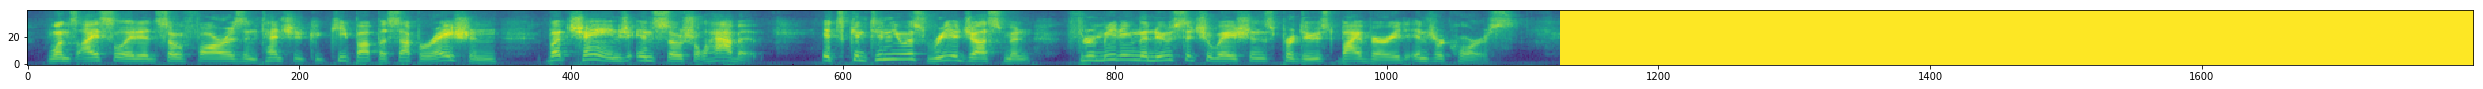

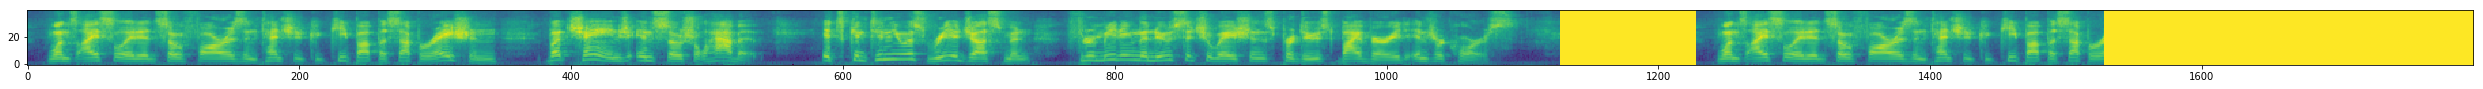

In [177]:

fig, ax = plt.subplots(figsize=(50,1))
mfcc_data= np.swapaxes(inputs_check["log_mfes"][0], 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest' , origin='lower')


fig, ax = plt.subplots(figsize=(50,1))
mfcc_data= np.swapaxes(inputs_mutated["log_mfes"][0], 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest' , origin='lower')
ctc_cost, probs = model.predict(inputs_check)
print ctc_cost
ctc_cost_mutated, probs_mutated = model.predict(inputs_mutated)
print ctc_cost_mutated

* By changing insert_after, we observe that the insertion only changes the loss when it is below some small amount.
* This amount is probably half the rf size of the model.
* Thus we don't need to worry about not masking the input, really.

In [187]:
changing_idx = 10

inputs_check = {k:v[[0, 1]] for (k,v) in inputs_valid.items()}
from copy import deepcopy
inputs_mutated = deepcopy(inputs_check)
labels = inputs_check["the_labels"][0]
# inputs_mutated["input_length"][0]+=400
inputs_mutated["the_labels"][0, changing_idx]=0
labels_mutated=inputs_mutated["the_labels"][0]
print [i for i,b in enumerate(labels==labels_mutated) if not b]
print "ctc costs on two unmutated inputs:"
ctc_cost, probs = model.predict(inputs_check)
print ctc_cost
print "ctc costs on one mutated input and one unmutated input:"
ctc_cost_mutated, probs_mutated = model.predict(inputs_mutated)
print ctc_cost_mutated

[10]
ctc costs on two unmutated inputs:
[[ 270.08624268]
 [ 230.09107971]]
ctc costs on one mutated input and one unmutated input:
[[ 272.09448242]
 [ 230.09107971]]
